In [1]:
from __future__ import division
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Background Knowledge

### 0.0 Sample from a multivariant Gaussian distribution
We have a multivariate normal vector ${\boldsymbol Y} \sim \mathcal{N}(\boldsymbol\mu, \Sigma)$. Sampling ${\boldsymbol Y}$ directly from the ditribution is equavalent to:
- $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$
- Cholesky decomposition on $\Sigma$ such that. $\Sigma=\boldsymbol{L}\cdot\boldsymbol{L}^{T}$.
- $\boldsymbol{Y} = \boldsymbol\mu + \boldsymbol{L}\boldsymbol{x}$

### 0.1 Block conditional distribution

We have a multivariate normal vector ${\boldsymbol Y} \sim \mathcal{N}(\boldsymbol\mu, \Sigma)$. Consider partitioning $\boldsymbol\mu$ and ${\boldsymbol Y}$ into 
$$
\boldsymbol\mu= \begin{bmatrix} \boldsymbol\mu_1 \\ \boldsymbol\mu_2 \end{bmatrix},
{\boldsymbol Y}=\begin{bmatrix}{\boldsymbol y}_1 \\ {\boldsymbol y}_2 \end{bmatrix}
$$
with a similar partition of $\Sigma$ into
$$ 
\Sigma = \begin{bmatrix} \Sigma_{11} \Sigma_{12}\\ \Sigma_{21} \Sigma_{22} \end{bmatrix}
$$
Then, $({\boldsymbol y}_1|{\boldsymbol y}_2={\boldsymbol a})$, the conditional distribution of the first partition given the second, is 
$\mathcal{N}(\overline{\boldsymbol\mu},\overline{\Sigma})$, with mean
$$
\overline{\boldsymbol\mu}=\boldsymbol\mu_1+\Sigma_{12}{\Sigma_{22}}^{-1}({\boldsymbol a}-\boldsymbol\mu_2)
$$
and covariance matrix
$$
\overline{\Sigma}=\Sigma_{11}-\Sigma_{12}{\Sigma_{22}}^{-1}\Sigma_{21}$$

# Prior Gaussian Processes

For N data points $X_1 = \{x_1, \cdots, x_N\}$, the objective is to model the distribution of $\boldsymbol{y_1}= \{y_1, \cdots, y_N\}$.

By assumption: 
$\boldsymbol{y_1} \sim \mathcal{N}(\boldsymbol\mu, \Sigma)$ where $\Sigma_{ij} = \mathcal{K}(x_i, x_j)$. $\mathcal{K}$ is a kernel function definined to measure the correlation between $x_i$ and $x_j$. Kernel $\mathcal{K}$ is chosen such that $\Sigma$ is a proper covariance matrix:
- symmetric
- semi-definite => $\mathcal{K}(x_i,x_j)$ is maximized when $x_i = x_j$. 

The plot below is genearted by sampling from $\boldsymbol{y_1} \sim \mathcal{N}(\boldsymbol\mu, \Sigma)$ with the method descirbed in Section 0.0. Each line corresponds to a sample $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$.

In [2]:
n_predict = 50 # number of datapoints to predict
X_1 = np.linspace(-5, 5, n_predict).reshape(-1,1) # test points

n_gp_samples = 10 # number of samples from GP

In [3]:
def kernel(X_1, X_2, sigma=1, kernel_width=1):
    """
    INPUT:
        X_1: N*D np.array
        X_2: N*D np.array
        sigma: a constant
        l: width of the kernel
    OUTPUT:
        N*N np.array
    """
    square_distance = np.sum(X_1 ** 2, 1).reshape(-1,1) + np.sum (X_2 ** 2, 1) \
                        - 2 * np.dot(X_1, X_2.T)
    return sigma**2*np.exp(- 0.5 * square_distance / l**2)

In [4]:
l = 1 #width of kernel, smaller l leads to stronger smoothness assumption

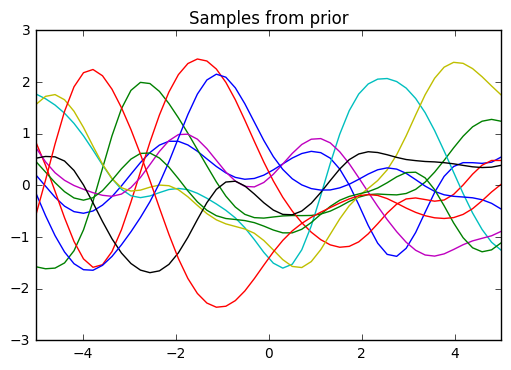

In [5]:
# Step1: compute covariance matrix K_
K_11 = kernel(X_1, X_1, kernel_width=l)
# Step2: sample Y from Y~ N(0, K_). It assumes a zero mean GP Prior
L_11 = np.linalg.cholesky(K_11 + 1e-6*np.eye(n_predict))
f_prior  = np.dot(L_11, np.random.normal(size=(n_predict, n_gp_samples)))


plt.plot(X_1, f_prior)
plt.title("Samples from prior")
plt.axis([-5, 5, -3, 3])
plt.savefig('figures/gp_demo_prior.png', bbox_inches='tight')

# Posterior Gaussian Processes

Joint prior distribution of $\boldsymbol{y_1}$ and $\boldsymbol{y_2}$ given $X_1$ and $X_2$: ${\boldsymbol Y} \sim \mathcal{N}(\boldsymbol\mu, \Sigma)$. 
$$
\boldsymbol\mu= \begin{bmatrix} \boldsymbol\mu_1 \\ \boldsymbol\mu_2 \end{bmatrix},
{\boldsymbol Y}=\begin{bmatrix}{\boldsymbol y}_1 \\ {\boldsymbol y}_2 \end{bmatrix}
$$
with a similar partition of $\Sigma$ into
$$ 
\Sigma = \begin{bmatrix} \Sigma_{11} \Sigma_{12}\\ \Sigma_{21} \Sigma_{22} \end{bmatrix},
$$
where $\Sigma_{ij} = \mathcal{K}_{i,j} = \text{kernel}(X_i, X_j)$

If some data points $\{\boldsymbol{X_2}, \boldsymbol{y_2}\}$ are observed, then the posterior distribution of $\boldsymbol{y_1}|\boldsymbol{y_2}=\boldsymbol{a} \sim \mathcal{N}(\overline{\boldsymbol\mu},\overline{\Sigma})$, with mean
$$
\overline{\boldsymbol\mu}=\boldsymbol\mu_1+\mathcal{K}_{12}{\mathcal{K}_{22}}^{-1}({\boldsymbol a}-\boldsymbol\mu_2)
$$
and covariance matrix
$$
\overline{\Sigma}=\mathcal{K}_{11}-\mathcal{K}_{12}{\mathcal{K}_{22}}^{-1}\mathcal{K}_{21},
$$
where $\mathcal{K}_{i,j}$ can be computed by feeding $\boldsymbol{X_i}$ and $\boldsymbol{X_j}$ into the kernel function, $\boldsymbol {\mu_1}$ and $\boldsymbol \mu_2$ are the means of $\boldsymbol y_1$ and $\boldsymbol y_2$ specified in the prior distribution.

In [6]:
# Observe the data: suppose the corresonding y value of X_test are observed
n_observed = 10 # number of datapoints observed
s = 0 # noise added to kernel matrix

# This is the true unknown function we are trying to approximate
#f = lambda x: np.sin(0.9*x).flatten()
f = lambda x : 0
X_2 = np.random.uniform(-5, 5, size=(n_observed,1))
y_2 = f(X_2) + s*np.random.randn(n_observed)

In [7]:
K_22 = kernel(X_2, X_2, kernel_width=l)
K_21 = kernel(X_2, X_1, kernel_width=l)
L_22 = np.linalg.cholesky(K_22 + 1e-6 * np.eye(n_observed))
Lk = np.linalg.solve(L_22, K_21) #L_22^(-1) * K_21
mu_bar = np.dot(Lk.T, np.linalg.solve(L_22, y_2)) # K_12 *L_22^(-1).T * L_22^(-1)* y_2
Sigma_bar = K_11 - np.dot(Lk.T, Lk)

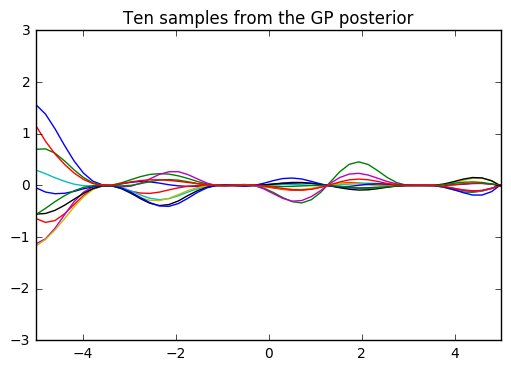

In [8]:
# draw samples from the posterior at our test points.
L_bar = np.linalg.cholesky(Sigma_bar + 1e-6*np.eye(n_predict))
f_post = mu_bar.reshape(-1,1) + np.dot(L_bar, np.random.normal(size=(n_predict,10)))

plt.plot(X_1, f_post)
plt.title('Ten samples from the GP posterior')
plt.axis([-5, 5, -3, 3])
plt.savefig('figures/gp_demo_posterior.png', bbox_inches='tight')

visualize variance of marginal distribution of each data point...

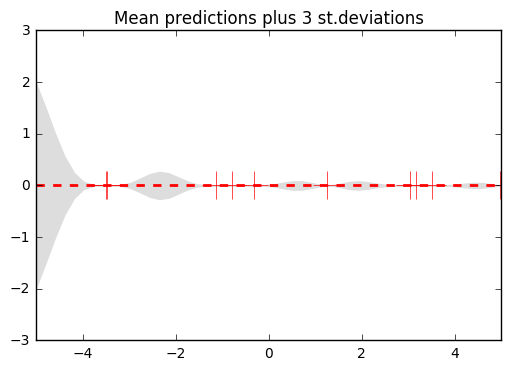

In [10]:
diag_22 = np.diag(Sigma_bar) # std of for each datapoint in X_1

plt.plot(X_2, y_2, 'r+', ms=20)
#plt.plot(X_1, f(X_1), 'b-')
plt.gca().fill_between(X_1.flat, mu_bar-3*diag_22, mu_bar+3*diag_22, color="#dddddd")
plt.plot(X_1, mu_bar, 'r--', lw=2)
plt.title('Mean predictions plus 3 st.deviations')
plt.axis([-5, 5, -3, 3])
plt.savefig('figures/gp_demo_predictive.png', bbox_inches='tight')

- Noisy GP regression : Add noise in $y_1$ to Sigma_11. Keep other parts the same.
$y = f(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma_y^2)$. Then cov[y|X] = $\Sigma_{11} + \sigma_y^2$.

- Learn the kernel parameters: MLE w.r.t. kernel parameters.

- Application: Active learning, Bayesian optimization, GP bandits
    - Active learning: if the objective of to model the underlying $f(\cdot)$ in an active fashion, select $x_{i+1}$ with highest variances under GP fitted to $\{x_1, \cdots, x_i\}$, to get evidence in areas with high uncertainty.
    - Bayesian optimzation: 
        - A sequential strategy optimizes a function without explicitly knowing the function. The mechanism is, each time an $x$ that maximizes the acquisition function (e.g. probability of improvement, expected improvement, Bayesian expected losses, upper confidence bounds (UCB), Thompson sampling and mixtures of these) is queried with respect to its $f(x)$. For example, in the case of Bayesian optimization for hyperparameter tuning, a $x$ is a hyperparameter setting, and $f(x)$ is the converged objective function under this hyperparameter setting. (can be very expensive)
        - Aquisition functions all trade-off exploration and exploitation so as to minimize the number of function queries.
            - Exploit: it is likely that the optimal $x$ is near $x^*= argmax_x\{f(x_1), f(x_2),\cdots, f(x_i)\}$. In order to fully exploit the current optimal, one may want to keep $x_{i+1}$ near $x^*$.
            - Explore: the previous strategy has the risk of missing optimal $x$ in unexplored areas, e.g. areas with high variance and large amount of probability mass on $\{f(x) > f(x^*)\}$